In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
couponitemmapping = pd.read_csv('coupon_item_mapping.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [3]:
len(couponitemmapping)

92663

In [4]:
item_data = pd.read_csv('item_data.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [5]:
item_data.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [6]:
items = item_data

In [7]:
items.loc[items['brand_type'].str.match('Local')==True,'brand_type'] = 0

In [8]:
items.loc[items['brand_type'].str.match('Established')==True,'brand_type'] = 1

In [9]:
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
items['category'] = number.fit_transform(items['category'].astype('str'))

In [11]:
len(items)

74066

In [12]:
step1 = pd.merge(couponitemmapping, items, how='left', on='item_id')

In [13]:
customer_transaction_data = pd.read_csv('customer_transaction_data.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [14]:
transactions = customer_transaction_data

In [15]:
len(step1)

92663

In [16]:
transactions['redemption'] = 1
transactions.loc[transactions['coupon_discount']==0,'redemption'] = '0'
transactions.loc[transactions['other_discount']==0,'redemption'] = '0'

In [17]:
transactions['selling_price'] = transactions['selling_price']/transactions['quantity']
transactions['other_discount'] = transactions['other_discount']/transactions['quantity']
transactions['selling_price'] = transactions['selling_price'] - transactions['other_discount']

In [18]:
transactions = transactions.astype({"redemption": int})

In [19]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions = transactions.sort_values('date').reset_index(drop=True)

In [ ]:
transactions['jour'] = transactions["date"].apply(lambda x: x.day)
transactions['week'] = transactions["date"].apply(lambda x: x.weekday())
transactions['mois'] = transactions["date"].apply(lambda x: x.month)

In [21]:
transactionsx1 = pd.pivot_table(transactions, index = "item_id",
                              values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount','redemption'],
                              aggfunc={'customer_id':lambda x: len(set(x)),
                                       'quantity':np.mean,
                                       'selling_price':np.mean,
                                       'other_discount':np.mean,
                                       'coupon_discount':np.mean,
                                       'redemption': np.sum} )

In [22]:
transactionsx1.reset_index(inplace=True)
transactionsx1.rename(columns={'customer_id': 'nb_customers'}, inplace=True)

In [23]:
transactionsx2 = pd.pivot_table(transactions, index = "item_id",
                               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount'],
                                aggfunc={'customer_id':len,
                                         'quantity':np.sum,
                                         'selling_price':np.sum,
                                         'other_discount':np.sum,
                                         'coupon_discount':np.sum} )

In [24]:
transactionsx2.reset_index(inplace=True)
transactionsx2.rename(columns={'customer_id': 'tot_counts', 'quantity':'qua_sum','selling_price':'prix_sum', 'other_discount':'oth_sum','coupon_discount':'coup_sum'}, inplace=True)

In [25]:
transactionsx3 = pd.merge(transactionsx1, transactionsx2, on='item_id', how='left')

In [26]:
transactionsx3['total_dsc_mean'] = transactionsx3['coupon_discount'] + transactionsx3['other_discount']
transactionsx3['total_dsc_sum'] = transactionsx3['oth_sum'] + transactionsx3['coup_sum']
transactionsx3.head()

,item_id,coupon_discount,nb_customers,other_discount,quantity,redemption,selling_price,coup_sum,tot_counts,oth_sum,qua_sum,prix_sum,total_dsc_mean,total_dsc_sum
0,1,0.0,2,0.0,1.0,0,124.31,0.0,2,0.0,2,248.62,0.0,0.0
1,2,0.0,1,0.0,1.0,0,35.26,0.0,1,0.0,1,35.26,0.0,0.0
2,3,0.0,1,0.0,1.0,0,56.64,0.0,1,0.0,1,56.64,0.0,0.0
3,4,0.0,1,0.0,1.0,0,54.85,0.0,1,0.0,1,54.85,0.0,0.0
4,5,0.0,1,0.0,1.0,0,81.57,0.0,1,0.0,1,81.57,0.0,0.0


In [27]:
step2 = pd.merge(step1, transactionsx3, how='left', on='item_id')

In [28]:
from scipy.stats import mode

In [29]:
coupon_table = pd.pivot_table(step2, index ="coupon_id",
                        values=[ 'item_id', 'brand', 'brand_type', 'category',
                                'coupon_discount', 'redemption', 'nb_customers', 'other_discount',
                                'quantity', 'selling_price', 'coup_sum', 'tot_counts', 'oth_sum', 'qua_sum',
                                'prix_sum', 'total_dsc_mean', 'total_dsc_sum'],
                        aggfunc={'item_id':lambda x: len(set(x)),
                       'brand':lambda x: mode(x)[0][0],
                       'brand_type':lambda x: mode(x)[0][0],
                       'category':lambda x: mode(x)[0][0],
                       'coupon_discount':np.mean,
                       'nb_customers':np.mean,
                       'other_discount':np.mean,
                       'quantity':np.mean,
                       'selling_price':np.mean,
                      'redemption': np.sum,
                       'coup_sum': np.sum,
                       'tot_counts': np.sum,
                       'oth_sum': np.sum,
                       'qua_sum': np.sum,
                       'prix_sum': np.sum,
                       'total_dsc_mean': np.mean,
                       'total_dsc_sum': np.sum
                      })

In [30]:
coupon_table.reset_index(inplace=True)

In [31]:
coupon_table.rename(columns={'item_id':'item_counts'}, inplace=True)

In [32]:
coupon_table.rename(columns={'item_id':'nb_item_counts'}, inplace=True)

In [33]:
transactionsy3 = pd.pivot_table(transactions, index = "customer_id",
                                values=['item_id','quantity','selling_price', 'other_discount','coupon_discount','redemption','jour','week','mois'],
                                aggfunc={'item_id':lambda x: len(set(x)),
                                         'quantity':np.mean,
                                         'selling_price':np.mean,
                                         'other_discount':np.mean,
                                         'coupon_discount':np.mean,
                                         'redemption': np.sum,
                                         'jour':lambda x: mode(x)[0][0],
                                         'week':lambda x: mode(x)[0][0],
                                         'mois':lambda x: mode(x)[0][0]})

In [34]:
transactionsy3.reset_index(inplace=True)
transactionsy3.rename(columns={'item_id': 'nbo_items'}, inplace=True)
transactionsy3.head()

,customer_id,coupon_discount,nbo_items,jour,mois,other_discount,quantity,redemption,selling_price,week
0,1,-2.019876,463,3,5,-12.837537,1.170802,45,97.470480,3
1,2,-0.595084,352,13,6,-13.432195,1.131265,2,107.805783,5
2,3,-3.091546,406,16,7,-14.074853,11.578723,28,85.082452,4
3,4,-0.404773,125,14,5,-8.883656,1.272727,1,138.256770,5
4,5,-0.114684,490,11,5,-11.260696,117.869949,2,115.482842,1


In [35]:
transactionsy4 = pd.pivot_table(transactions, index = "customer_id",
                                values=['item_id','quantity','selling_price', 'other_discount','coupon_discount'],
                                aggfunc={'item_id':len,
                                         'quantity':np.sum,
                                         'selling_price':np.sum,
                                         'other_discount':np.sum,
                                         'coupon_discount':np.sum})

In [36]:
transactionsy4.reset_index(inplace=True)
transactionsy4.rename(columns={'item_id': 'cust_id_count','quantity':'qoa_sum','selling_price':'prec_sum',
                             'other_discount':'othe_sum','coupon_discount':'code_sum'  }, inplace=True)
transactionsy4.head()

,customer_id,code_sum,cust_id_count,othe_sum,qoa_sum,prec_sum
0,1,-2116.83,1048,-13453.738833,1227,102149.063000
1,2,-249.34,419,-5628.089833,474,45170.623167
2,3,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-89.05,220,-1954.404333,280,30416.489333
4,5,-90.83,792,-8918.471477,93353,91462.410620


In [37]:
transactionsz = pd.merge(transactionsy3, transactionsy4, how='left',on='customer_id')
transactionsz.head()

,customer_id,coupon_discount,nbo_items,jour,mois,other_discount,quantity,redemption,selling_price,week,code_sum,cust_id_count,othe_sum,qoa_sum,prec_sum
0,1,-2.019876,463,3,5,-12.837537,1.170802,45,97.470480,3,-2116.83,1048,-13453.738833,1227,102149.063000
1,2,-0.595084,352,13,6,-13.432195,1.131265,2,107.805783,5,-249.34,419,-5628.089833,474,45170.623167
2,3,-3.091546,406,16,7,-14.074853,11.578723,28,85.082452,4,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-0.404773,125,14,5,-8.883656,1.272727,1,138.256770,5,-89.05,220,-1954.404333,280,30416.489333
4,5,-0.114684,490,11,5,-11.260696,117.869949,2,115.482842,1,-90.83,792,-8918.471477,93353,91462.410620


In [38]:
campaign_data = pd.read_csv('campaign_data.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [40]:
campaign = campaign_data

In [41]:
campaign.loc[campaign['campaign_type'].str.match('Y')==True,'campaign_type'] = 0

In [42]:
campaign.loc[campaign['campaign_type'].str.match('X')==True,'campaign_type'] = 1

In [43]:
campaign['duration'] = pd.to_datetime(campaign['end_date']) - pd.to_datetime(campaign['start_date'])

In [44]:
campaign['duration'] = campaign['duration'].dt.days

In [45]:
campaign['start_date'] = pd.to_datetime(campaign['start_date'], format = '%d/%m/%y')
campaign['end_date'] = pd.to_datetime(campaign['end_date'], format = '%d/%m/%y')

In [46]:
campaign = campaign.astype({"campaign_type": int})

In [47]:
customer_demographics = pd.read_csv('customer_demographics.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [48]:
customer_demographics.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [49]:
customerv2 = customer_demographics

In [50]:
customerv2.loc[customerv2['marital_status'].isna()==True,'marital_status'] = 'Single'

In [51]:
customerv2.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,Single,0,3,1,3
3,8,26-35,Single,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [52]:
customerv2.loc[customerv2['no_of_children'].isna()==True]

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
4,10,46-55,Single,0,1,NaN,5
5,11,70+,Single,0,2,NaN,1
6,12,46-55,Married,0,2,NaN,7
...,...,...,...,...,...,...,...
753,1573,46-55,Single,0,1,NaN,4
754,1574,36-45,Married,0,2,NaN,5
755,1577,36-45,Single,0,2,NaN,5
757,1579,46-55,Single,0,1,NaN,4


In [53]:
customerv2.loc[customerv2['no_of_children'].isna()==True,'no_of_children'] = '2'

In [54]:
customerv2.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,2,4
1,6,46-55,Married,0,2,2,5
2,7,26-35,Single,0,3,1,3
3,8,26-35,Single,0,4,2,6
4,10,46-55,Single,0,1,2,5


In [55]:
dummies_v1 = pd.get_dummies(customerv2.age_range).add_prefix('cust_age_')

In [56]:
dummies_v2 = pd.get_dummies(customerv2.marital_status).add_prefix('cust_marit_')

In [57]:
dummies_v3 = pd.get_dummies(customerv2.no_of_children).add_prefix('cust_child_')

In [58]:
dummies_v4 = pd.get_dummies(customerv2.income_bracket).add_prefix('cust_inco_')

In [59]:
dummies_v5 = pd.get_dummies(customerv2.family_size).add_prefix('cust_fam_')

In [60]:
dummies_v3.head()

,cust_child_1,cust_child_2,cust_child_3+
0,0,1,0
1,0,1,0
2,1,0,0
3,0,1,0
4,0,1,0


In [61]:
cust_merged = pd.concat([customerv2, dummies_v1,dummies_v2,dummies_v3,dummies_v4,dummies_v5], axis='columns')

In [62]:
demographics = cust_merged.drop(['age_range', 'income_bracket','family_size','no_of_children','marital_status'], axis='columns')

In [63]:
demographics.head()

,customer_id,rented,cust_age_18-25,cust_age_26-35,cust_age_36-45,cust_age_46-55,cust_age_56-70,cust_age_70+,cust_marit_Married,cust_marit_Single,...,cust_inco_8,cust_inco_9,cust_inco_10,cust_inco_11,cust_inco_12,cust_fam_1,cust_fam_2,cust_fam_3,cust_fam_4,cust_fam_5+
0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,6,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,7,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,8,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,10,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [64]:
train_data = pd.read_csv('train.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [65]:
train= train_data

In [66]:
test_data = pd.read_csv('test.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [67]:
test = test_data

In [108]:
xx = pd.merge(train, coupon_table, on="coupon_id", how="left")
yy = pd.merge(xx, campaign, on="campaign_id", how="left")
zz = pd.merge(yy, demographics, on="customer_id", how="left")
ww = pd.merge(zz, transactionsz, on='customer_id', how='left')

In [69]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [70]:
coupon_table.head()

,coupon_id,brand,brand_type,category,coup_sum,coupon_discount,item_counts,nb_customers,oth_sum,other_discount,prix_sum,qua_sum,quantity,redemption,selling_price,tot_counts,total_dsc_mean,total_dsc_sum
0,1,1475,1,9,-1526.31,-1.321524,39,14.794872,-18780.020833,-16.620713,89796.868333,1034.0,1.221644,20.0,101.183245,826.0,-17.942237,-20306.330833
1,2,2084,1,6,0.00,0.000000,2,15.000000,-1163.521667,-21.343885,8940.520000,103.0,1.137500,0.0,122.534500,81.0,-21.343885,-1163.521667
2,3,278,1,6,-578.81,-2.747358,17,8.588235,-4055.343333,-14.728021,27756.490000,248.0,1.121525,10.0,131.655894,212.0,-17.475379,-4634.153333
3,4,544,1,6,-881.59,-1.485152,24,22.333333,-25895.740000,-36.718597,142874.023333,702.0,1.020872,43.0,211.708369,676.0,-38.203749,-26777.330000
4,5,5357,1,11,0.00,0.000000,7,6.000000,-1228.880000,-27.265786,16636.570000,44.0,1.000000,0.0,403.970000,44.0,-27.265786,-1228.880000


In [71]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date,duration
0,24,0,2013-10-21,2013-12-20,60
1,25,0,2013-10-21,2013-11-22,32
2,20,0,2013-09-07,2013-11-16,130
3,23,0,2013-10-08,2013-11-15,97
4,21,0,2013-09-16,2013-10-18,32


In [72]:
transactionsz.head()

,customer_id,coupon_discount,nbo_items,jour,mois,other_discount,quantity,redemption,selling_price,week,code_sum,cust_id_count,othe_sum,qoa_sum,prec_sum
0,1,-2.019876,463,3,5,-12.837537,1.170802,45,97.470480,3,-2116.83,1048,-13453.738833,1227,102149.063000
1,2,-0.595084,352,13,6,-13.432195,1.131265,2,107.805783,5,-249.34,419,-5628.089833,474,45170.623167
2,3,-3.091546,406,16,7,-14.074853,11.578723,28,85.082452,4,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-0.404773,125,14,5,-8.883656,1.272727,1,138.256770,5,-89.05,220,-1954.404333,280,30416.489333
4,5,-0.114684,490,11,5,-11.260696,117.869949,2,115.482842,1,-90.83,792,-8918.471477,93353,91462.410620


In [73]:
ww

,id,campaign_id,coupon_id,customer_id,redemption_status,brand,brand_type,category,coup_sum,coupon_discount_x,...,other_discount_y,quantity_y,redemption_y,selling_price_y,week,code_sum,cust_id_count,othe_sum,qoa_sum,prec_sum
0,1,13,27,1053,0,1105,1,6,-5349.93,-1.241694,...,-25.583099,340.487097,1,163.966826,2,-89.05,310,-7930.760842,105551,50829.715972
1,2,13,116,48,0,56,0,6,0.00,0.000000,...,-20.013685,31.540260,4,188.638474,5,-1237.79,385,-7705.268702,12143,72625.812434
2,6,9,635,205,0,560,1,11,-605.54,-2.987321,...,-12.873370,1.392784,51,112.067666,2,-2145.72,970,-12487.169143,1351,108705.636349
3,7,13,644,1050,0,611,1,6,-17.81,-4.452500,...,-12.880868,1.291139,2,100.896997,4,-178.10,237,-3052.765833,306,23912.588333
4,9,8,1017,1489,0,1558,1,6,-569.92,-0.198055,...,-12.264174,247.443060,3,85.016352,4,-265.01,562,-6892.466021,139063,47779.189609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78364,128587,8,71,1523,0,56,0,6,0.00,0.000000,...,-8.282240,1.064935,0,119.448066,3,0.00,462,-3826.395000,492,55185.006667
78365,128589,30,547,937,0,2188,1,6,-35.62,-0.010943,...,-13.204228,1.206226,1,91.641946,6,-89.05,257,-3393.486667,310,23551.980000
78366,128590,8,754,1004,0,864,1,6,-6666.28,-3.239522,...,-11.887330,92.930028,4,99.589878,4,-260.03,1815,-21575.503851,168668,180755.627932
78367,128592,13,134,71,0,11,0,6,0.00,0.000000,...,-17.540946,19.131130,40,85.425052,6,-1325.04,938,-16453.407713,17945,80128.698841


In [109]:
ww.drop(['id','campaign_id','start_date','end_date'], axis=1, inplace=True)

In [110]:
ww = ww.dropna()

In [111]:
ww = ww.astype(float)

In [112]:
wiw = ww

In [88]:
wow = ww

In [78]:
wiw.drop(['redemption_status',
'brand_type',
'campaign_type',
'cust_age_18-25',
'cust_age_26-35',
'cust_age_36-45',
'cust_age_46-55',
'cust_age_56-70',
'cust_age_70+',
'cust_marit_Married',
'cust_marit_Single',
'cust_child_1',
'cust_child_2',
'cust_child_3+',
'cust_inco_1',
'cust_inco_2',
'cust_inco_3',
'cust_inco_4',
'cust_inco_5',
'cust_inco_6',
'cust_inco_7',
'cust_inco_8',
'cust_inco_9',
'cust_inco_10',
'cust_inco_11',
'cust_inco_12',
'cust_fam_1',
'cust_fam_2',
'cust_fam_3',
'cust_fam_4',
'cust_fam_5+'], axis=1, inplace=True)

In [ ]:
#removing the variables to get the vif

In [115]:
wiw.drop(['coup_sum',
'coupon_discount_x',
'item_counts',
'oth_sum',
'other_discount_x',
'prix_sum',
'qua_sum',
'redemption_x',
'tot_counts',
'total_dsc_mean',
'total_dsc_sum',
'redemption_y',
'code_sum',
'cust_id_count',
'othe_sum',
'prec_sum'], axis=1, inplace=True)

In [89]:
#After VIF validation
wow.drop(['category',
'coup_sum',
'coupon_discount_x',
'item_counts',
'oth_sum',
'other_discount_x',
'prix_sum',
'qua_sum',
'quantity_x',
'redemption_x',
'tot_counts',
'total_dsc_mean',
'total_dsc_sum',
'nbo_items',
'other_discount_y',
'redemption_y',
'selling_price_y',
'code_sum',
'cust_id_count',
'othe_sum',
'prec_sum'], axis=1, inplace=True)

In [116]:
y = wiw['redemption_status']
X = wiw.drop('redemption_status', axis = 1)

In [117]:
len(X)/len(y)

1.0

In [93]:
!pip3 install imblearn

In [94]:
import sklearn.metrics

In [95]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [86]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [96]:
from sklearn.datasets import load_diabetes

In [97]:
import sklearn
from sklearn.model_selection import train_test_split #sklearn import does not automatically install sub packages
from sklearn import linear_model
import statsmodels.api as sm

In [113]:
#calculate Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = wiw.columns 
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(wiw.values, i) for i in range(len(wiw.columns))] 
  
display(vif_scores)

C:\Users\daniel.galdo\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Attribute,VIF Scores
0,coupon_id,2.007762
1,customer_id,1.081651
2,redemption_status,1.046337
3,brand,1.396826
4,brand_type,2.444545
...,...,...
60,code_sum,15.471437
61,cust_id_count,64.435466
62,othe_sum,23.030530
63,qoa_sum,6.317490


In [114]:
vif_scores.loc[vif_scores['VIF Scores']>=10]

,Attribute,VIF Scores
6,coup_sum,inf
7,coupon_discount_x,inf
8,item_counts,61.526609
10,oth_sum,inf
11,other_discount_x,inf
12,prix_sum,512.635674
13,qua_sum,1399.952192
15,redemption_x,63.544209
17,tot_counts,1486.536377
18,total_dsc_mean,inf


In [142]:
X.drop(['coup_sum',
'coupon_discount_x',
'item_counts',
'oth_sum',
'other_discount_x',
'prix_sum',
'qua_sum',
'redemption_x',
'tot_counts',
'total_dsc_mean',
'total_dsc_sum',
'redemption_y',
'code_sum',
'cust_id_count',
'othe_sum',
'prec_sum'], axis=1, inplace=True)

In [98]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [112]:
#basex.to_csv(r'C:\Users\daniel.galdo\Documents\Thesis\basex.csv')

In [ ]:
#basex = pd.read_csv('basex.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [99]:
#spliting our data into training and testing features and targets
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size =0.3, random_state = 0)

In [118]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.056276
         Iterations: 35
                                  Results: Logit
Model:                    Logit                  Pseudo R-squared:      0.189      
Dependent Variable:       redemption_status      AIC:                   5002.1523  
Date:                     2022-12-07 23:53       BIC:                   5384.2575  
No. Observations:         43661                  Log-Likelihood:        -2457.1    
Df Model:                 43                     LL-Null:               -3030.6    
Df Residuals:             43617                  LLR p-value:           2.7856e-212
Converged:                0.0000                 Scale:                 1.0000     
No. Iterations:           35.0000                                                  
-----------------------------------------------------------------------------------
                    Coef.     Std.Err.      z     P>|z|      [0.025       0.975]   
---------------------------------------------

C:\Users\daniel.galdo\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [278]:
X.drop(['coupon_id',
'customer_id',
'brand',
'brand_type',
'category',
'item_counts',
'nb_customers',
'prix_sum',
'qua_sum',
'quantity_x',
'redemption_x',
'selling_price_x',
'tot_counts',
'campaign_type',
'duration',
'coupon_discount_y',
'nbo_items',
'mois',
'other_discount_y',
'quantity_y',
'redemption_y',
'selling_price_y',
'code_sum',
'cust_id_count',
'othe_sum',
'prec_sum'], axis=1, inplace=True)

In [162]:
len(X)/len(y)

1.0

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\daniel.galdo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [122]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.99


In [124]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier(criterion='gini')

model.fit(X_train,y_train)



In [128]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier(criterion='gini')

model.fit(X_train,y_train)

DecisionTreeClassifier()

In [138]:

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
(sum(y_pred)/len(y_pred))*100


1.610809985495076

In [139]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9733567447896786


Model accuracy score with criterion gini: 0.973


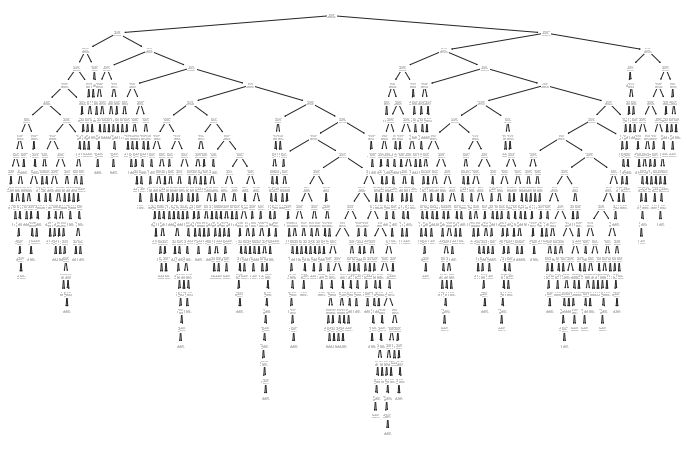

In [158]:
from sklearn.metrics import accuracy_score
print('Model accuracy score with criterion gini: {0:0.3f}'. format(accuracy_score(y_test, y_pred)))
y_pred_train = model.predict(X_train)
y_pred_train
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(model.fit(X_train, y_train))
fig.savefig('rf_individualtree.png')

In [159]:
from sklearn.metrics import confusion_matrix
confu = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', confu)

Confusion matrix

 [[12725   186]
 [  163    25]]
